In [2]:
import importlib
import pre_processing as prep
import sqlite3
import json
import datetime
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

conn = prep.connect_db("numero_data.sqlite")

# Load raw json
df_raw = prep.load_raw_sales(conn)
df_sales = prep.flatten_sales_json(df_raw)
prep.save_df_to_csv(df_sales, "sales_processed.csv")

# Dataset
df_meta, df_titles = prep.load_metadata_and_titles(conn) 
df = prep.join_sales_metadata(df_sales, df_meta, df_titles)

Loaded 100 raw film records.


Flattening sales JSON: 100%|██████████| 100/100 [00:00<00:00, 100.43it/s]


Successfully processed 65947 rows.


In [3]:
print(df.shape)
df.dtypes

(65947, 37)


numero_film_id                              int64
week_start_date                    datetime64[ns]
actual_sales_date                  datetime64[ns]
gross_today                               float64
gross_yesterday                           float64
paid_admissions                            object
state                                      object
region                                     object
city                                       object
theatre_name                               object
circuit_name                               object
cinema_rank_for_week                        int64
film_rank_at_cinema_for_week              float64
films_in_cinema_this_week                 float64
week_gross_at_cinema                      float64
weekend_gross_at_cinema                   float64
cumulative_gross_at_cinema                  int64
cumulative_admissions_at_cinema           float64
state_id                                    int64
region_id                                   int64


# QUESTION 1: How quickly do films generate the majority of their revenue?

In [4]:
# Overwrite lifetime_total in df
true_lifetime = (
    df.groupby('numero_film_id')['gross_today']
      .sum()
      .rename('lifetime_total_fixed')
      .reset_index()
)

df = df.merge(true_lifetime, on='numero_film_id', how='left')
df['lifetime_total'] = df['lifetime_total_fixed']
df = df.drop(columns=['lifetime_total_fixed'])

In [5]:
film_daily = (df.groupby(['numero_film_id','actual_sales_date'], as_index=False)
                .agg({'gross_today':'sum',
                      'lifetime_total':'first',
                      'title':'first',
                      'state':'first'}))
film_daily = film_daily.sort_values(['numero_film_id','actual_sales_date'])
film_daily['cum_gross'] = film_daily.groupby('numero_film_id')['gross_today'].cumsum()

# Scaling factor
film_sum = film_daily.groupby('numero_film_id')['gross_today'].sum()
lifetime = film_daily.groupby('numero_film_id')['lifetime_total'].first()
ratio = (film_sum / lifetime).replace([np.inf,-np.inf], np.nan).dropna()
scaling = ratio.median()
print("Scaling factor (median):", scaling)
film_daily['lifetime_total_scaled'] = film_daily['lifetime_total'] * scaling

# milestones by scaled lifetime
def milestones(group):
    start = group['actual_sales_date'].min()
    L = group['lifetime_total_scaled'].iloc[0]
    if pd.isna(L) or L <= 0:
        return pd.Series({'days_to_50pct': np.nan, 'days_to_80pct': np.nan})
    day50 = group.loc[group['cum_gross'] >= 0.5 * L, 'actual_sales_date'].min()
    day80 = group.loc[group['cum_gross'] >= 0.8 * L, 'actual_sales_date'].min()
    return pd.Series({
        'days_to_50pct': (day50 - start).days if pd.notnull(day50) else np.nan,
        'days_to_80pct': (day80 - start).days if pd.notnull(day80) else np.nan
    })

film_velocity = film_daily.groupby('numero_film_id').apply(milestones).reset_index()

# film-level data
film_meta = (df.groupby('numero_film_id', as_index=False)
               .agg({
                   'opening_screen_average':'first',
                   'lifetime_total':'first',
                   'title':'first',
                   'state':'first'
               }))

# Map state to short codes
film_meta['state_norm'] = film_meta['state'].astype(str).str.strip().str.lower()
state_map = {
    'new south wales (inc act)': 'NSW',
    'queensland': 'QLD',
    'victoria (inc tas)': 'VIC',
    'south australia': 'SA',
    'western australia': 'WA',
    'northern territory': 'NT'
}
film_meta['state_group'] = film_meta['state_norm'].map(state_map).fillna(film_meta['state_norm'])

# Merge scaled lifetime into film_meta and then into summary
# get one scaled lifetime per film from film_daily
scaled_lt = film_daily.groupby('numero_film_id', as_index=False)['lifetime_total_scaled'].first()
film_meta = film_meta.merge(scaled_lt, on='numero_film_id', how='left')

summary_state = film_velocity.merge(film_meta, on='numero_film_id', how='left')

# print(summary_state.groupby('state_group').agg(
#     films=('numero_film_id','count'),
#     valid_50=('days_to_50pct', lambda s: s.notna().sum()),
#     min_days_50=('days_to_50pct','min'),
#     max_days_50=('days_to_50pct','max'),
#     valid_80=('days_to_80pct', lambda s: s.notna().sum()),
#     min_days_80=('days_to_80pct','min'),
#     max_days_80=('days_to_80pct','max')
# ))

Scaling factor (median): 1.0


In [6]:
# Percentiles and shares by state for 50% and 80%
summary_table = summary_state.groupby('state_group').agg(
    n=('numero_film_id','count'),
    median_50=('days_to_50pct','median'),
    p25_50=('days_to_50pct', lambda s: s.quantile(0.25)),
    p75_50=('days_to_50pct', lambda s: s.quantile(0.75)),
    pct_le_7_50=('days_to_50pct', lambda s: (s <= 7).mean()*100),
    median_80=('days_to_80pct','median'),
    pct_le_14_80=('days_to_80pct', lambda s: (s <= 14).mean()*100)
).reset_index()
print(summary_table)

  state_group   n  median_50  p25_50  p75_50  pct_le_7_50  median_80  \
0         NSW  56        3.0     2.0    3.25    92.857143        6.0   
1         QLD   2        3.0     2.5    3.50   100.000000        6.5   
2          SA   3        8.0     6.0    8.50    33.333333       12.0   
3         VIC  25        3.0     3.0    7.00    80.000000        6.0   
4          WA  14        2.5     2.0    3.75    85.714286        5.0   

   pct_le_14_80  
0     98.214286  
1    100.000000  
2    100.000000  
3     92.000000  
4     85.714286  


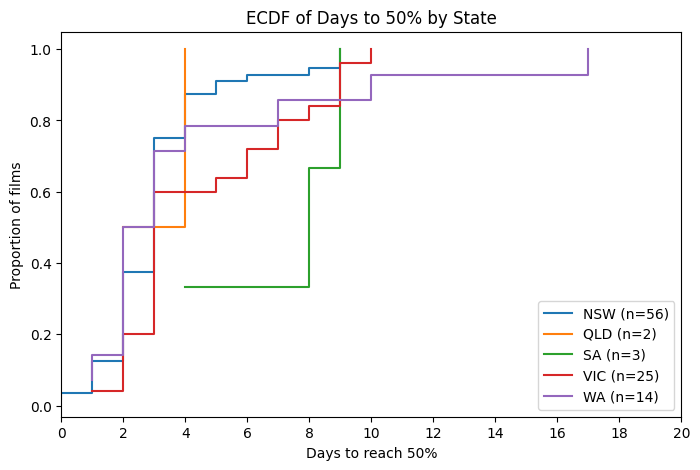

In [7]:
# ECDF per state for 50%
plt.figure(figsize=(8,5))
for state, grp in summary_state.groupby('state_group'):
    x = np.sort(grp['days_to_50pct'].dropna())
    y = np.arange(1, len(x)+1) / len(x)
    plt.step(x, y, where='post', label=f"{state} (n={len(x)})")
plt.xlim(0,20)
plt.xticks(list(range(0,21,2)))
plt.xlabel('Days to reach 50%')
plt.ylabel('Proportion of films')
plt.legend()
plt.title('ECDF of Days to 50% by State')
plt.show()

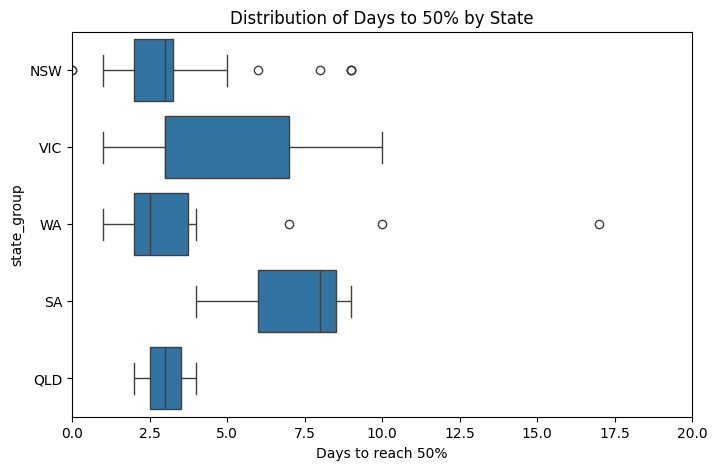

In [8]:
# Boxplot
plt.figure(figsize=(8,5))
sns.boxplot(data=summary_state, x='days_to_50pct', y='state_group', order=['NSW','VIC','WA','SA','QLD'])
plt.xlim(0,20)
plt.xlabel('Days to reach 50%')
plt.title('Distribution of Days to 50% by State')
plt.show()

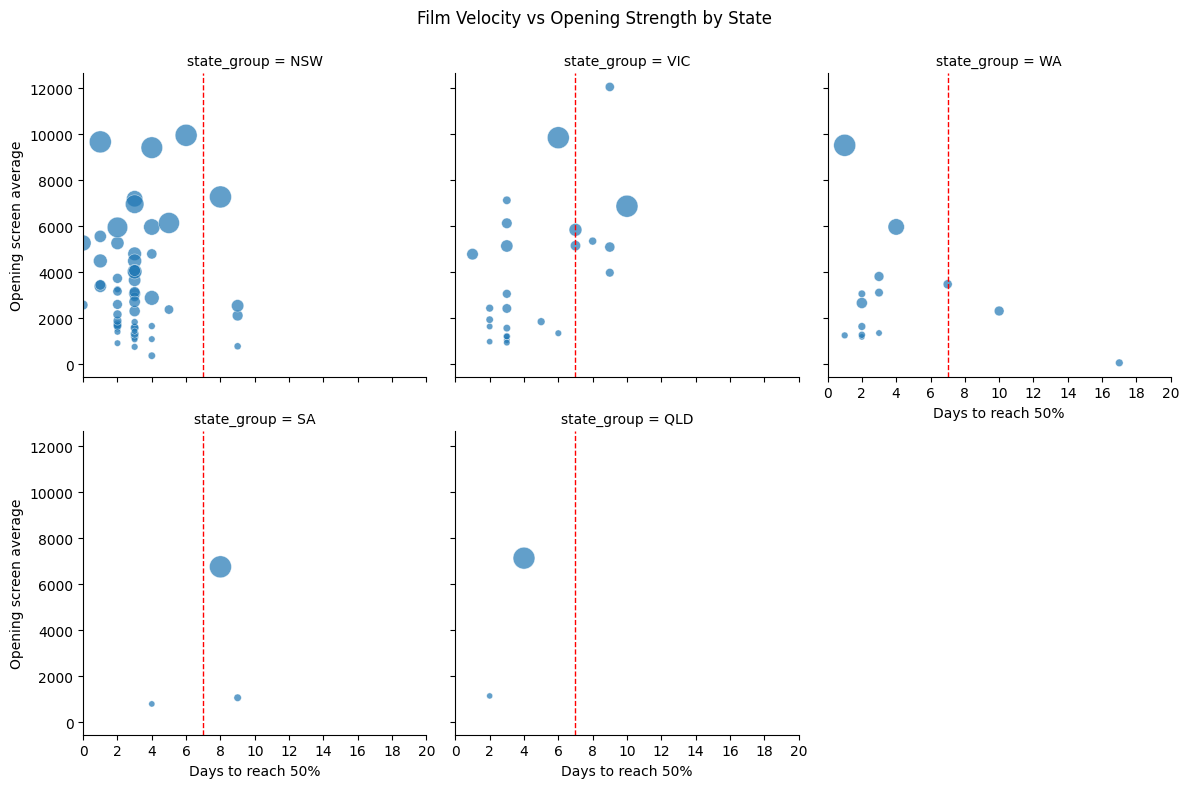

In [9]:
# Scatter plot
plot_df = summary_state.dropna(subset=['days_to_50pct','opening_screen_average','lifetime_total_scaled']).copy()
plot_df['days_to_50pct'] = plot_df['days_to_50pct'].clip(lower=0)
plot_df['size_plot'] = plot_df['lifetime_total_scaled'].clip(upper=plot_df['lifetime_total_scaled'].quantile(0.95))
plot_df['size_plot'] = (plot_df['size_plot'] / plot_df['size_plot'].max()) * 200 + 20

plot_df['beyond_20'] = plot_df['days_to_50pct'] > 20
plot_df.loc[plot_df['beyond_20'], 'days_to_50pct'] = 20

states_order = ['NSW','VIC','WA','SA','QLD']
g = sns.FacetGrid(plot_df, col='state_group', col_order=states_order, col_wrap=3, height=4, sharex=True, sharey=True)

def draw(data, color, **kwargs):
    ax = plt.gca()
    sns.scatterplot(data=data[~data['beyond_20']], x='days_to_50pct', y='opening_screen_average',
                    size='size_plot', sizes=(20,250), alpha=0.7, legend=False, ax=ax)
    if data['beyond_20'].any():
        sns.scatterplot(data=data[data['beyond_20']], x='days_to_50pct', y='opening_screen_average',
                        marker='X', color='black', s=60, ax=ax)

g.map_dataframe(draw)

for ax in g.axes.flat:
    ax.set_xlim(0,20)
    ax.set_xticks(list(range(0,21,2)))
    ax.axvline(7, color='red', linestyle='--', linewidth=1)
    ax.axvline(21, color='blue', linestyle='--', linewidth=1)
    ax.set_xlabel('Days to reach 50%')

g.set_axis_labels("Days to reach 50%","Opening screen average")
plt.subplots_adjust(top=0.90)
g.fig.suptitle("Film Velocity vs Opening Strength by State")
plt.show()

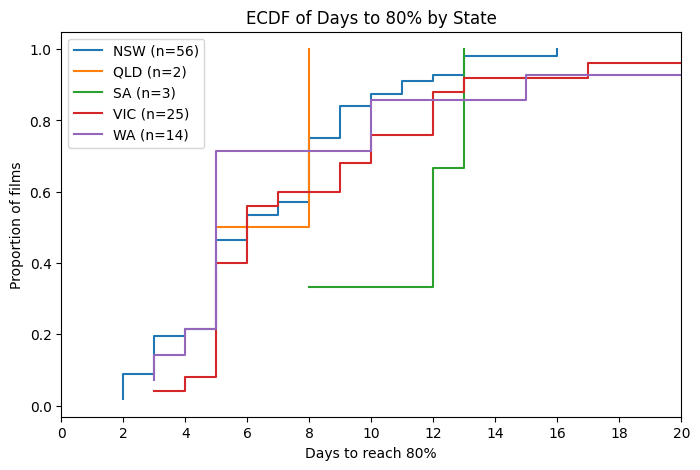

In [10]:
# ECDF per state for 80%
plt.figure(figsize=(8,5))
for state, grp in summary_state.groupby('state_group'):
    x = np.sort(grp['days_to_80pct'].dropna())
    y = np.arange(1, len(x)+1) / len(x)
    plt.step(x, y, where='post', label=f"{state} (n={len(x)})")
plt.xlim(0,20)
plt.xticks(list(range(0,21,2)))
plt.xlabel('Days to reach 80%')
plt.ylabel('Proportion of films')
plt.legend()
plt.title('ECDF of Days to 80% by State')
plt.show()

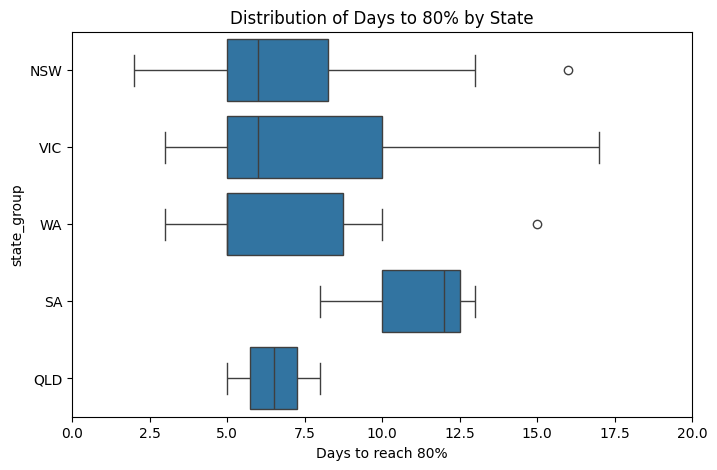

In [11]:
# Boxplot
plt.figure(figsize=(8,5))
sns.boxplot(data=summary_state, x='days_to_80pct', y='state_group', order=['NSW','VIC','WA','SA','QLD'])
plt.xlim(0,20)
plt.xlabel('Days to reach 80%')
plt.title('Distribution of Days to 80% by State')
plt.show()

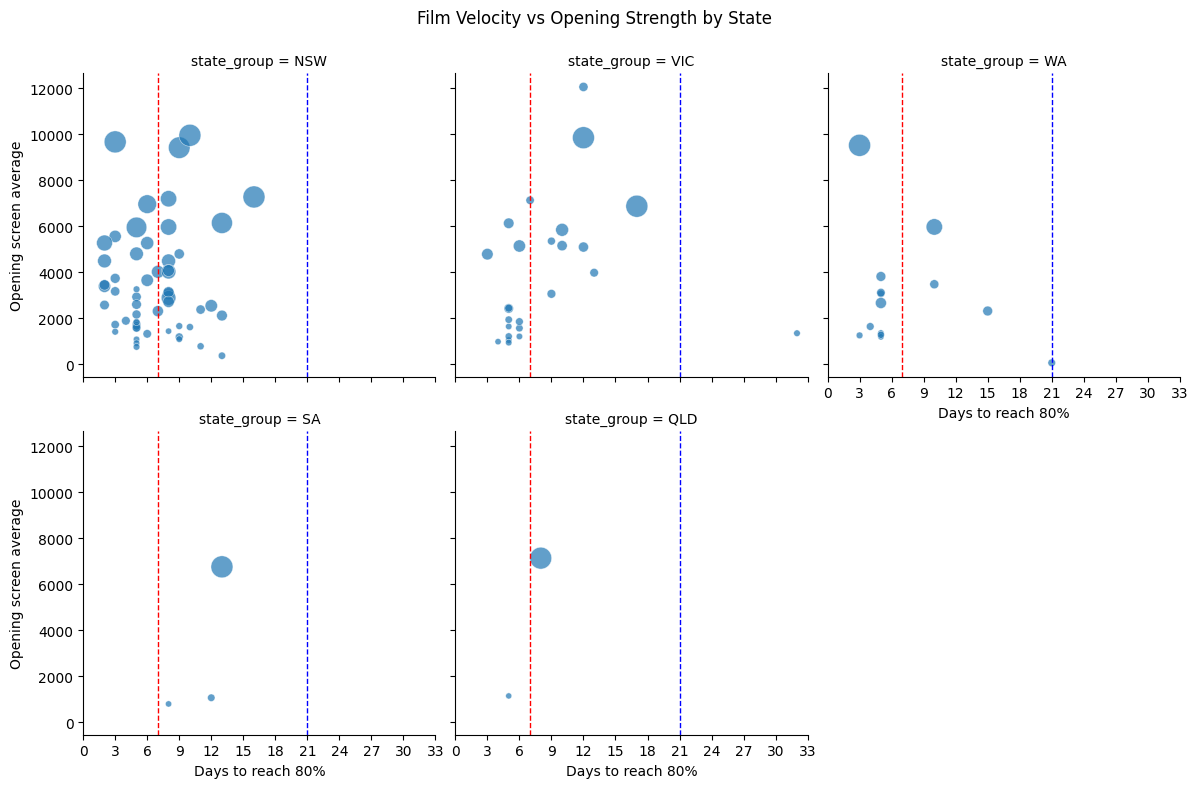

In [12]:
plot_df = summary_state.dropna(subset=['days_to_80pct','opening_screen_average','lifetime_total_scaled']).copy()
plot_df['days_to_80pct'] = plot_df['days_to_80pct'].clip(lower=0)
plot_df['size_plot'] = plot_df['lifetime_total_scaled'].clip(upper=plot_df['lifetime_total_scaled'].quantile(0.95))
plot_df['size_plot'] = (plot_df['size_plot'] / plot_df['size_plot'].max()) * 200 + 20

plot_df['beyond_35'] = plot_df['days_to_80pct'] > 35
plot_df.loc[plot_df['beyond_35'], 'days_to_80pct'] = 35

states_order = ['NSW','VIC','WA','SA','QLD']
g = sns.FacetGrid(plot_df, col='state_group', col_order=states_order, col_wrap=3, height=4, sharex=True, sharey=True)

def draw(data, color, **kwargs):
    ax = plt.gca()
    sns.scatterplot(data=data[~data['beyond_35']], x='days_to_80pct', y='opening_screen_average',
                    size='size_plot', sizes=(20,250), alpha=0.7, legend=False, ax=ax)
    if data['beyond_35'].any():
        sns.scatterplot(data=data[data['beyond_35']], x='days_to_80pct', y='opening_screen_average',
                        marker='X', color='black', s=60, ax=ax)

g.map_dataframe(draw)

for ax in g.axes.flat:
    ax.set_xlim(0,20)
    ax.set_xticks(list(range(0,36,3)))
    ax.axvline(7, color='red', linestyle='--', linewidth=1)
    ax.axvline(21, color='blue', linestyle='--', linewidth=1)
    ax.set_xlabel('Days to reach 80%')

g.set_axis_labels("Days to reach 80%","Opening screen average")
plt.subplots_adjust(top=0.90)
g.fig.suptitle("Film Velocity vs Opening Strength by State")
plt.show()

# QUESTION 2: What is the optimal run length for films?

# Continuous run problem

In [13]:
df['actual_sales_date'] = pd.to_datetime(df['actual_sales_date'])
dataset_end_date = df['actual_sales_date'].max()
film_dates = ( df.groupby('numero_film_id', as_index=False) 
              .agg(first_date=('actual_sales_date', 'min'), last_date=('actual_sales_date', 'max')) )
# duration_days = last_day - first_day + 1 (if you want inclusive count) 
film_dates['duration_days'] = (film_dates['last_date'] - film_dates['first_date']).dt.days + 1
# event_observed = 1 if last_day < dataset_end (film exited before dataset end), else 0 (censored) 
film_dates['event_observed'] = (film_dates['last_date'] < dataset_end_date).astype(int)
film_dates[['numero_film_id','first_date','last_date','duration_days','event_observed']].head(10)

,numero_film_id,first_date,last_date,duration_days,event_observed
0,48137,2025-02-20,2025-08-20,182,1
1,63815,2025-05-22,2025-06-04,14,1
2,64826,2025-03-13,2025-04-09,28,1
3,66112,2025-04-10,2025-04-23,14,1
4,68343,2025-01-16,2025-02-12,28,1
5,68556,2025-05-01,2025-08-27,119,1
6,71731,2025-07-31,2025-08-13,14,1
7,71733,2025-01-30,2025-02-26,28,1
8,73250,2025-02-27,2025-05-28,91,1
9,75788,2025-01-16,2025-01-29,14,1


In [14]:
ID = 48137
rows = df[df['numero_film_id'] == ID].sort_values('actual_sales_date')
# display(rows[['numero_film_id','title','actual_sales_date','gross_today','state','theatre_name','week']].head(200))

# summary
print("first_date:", rows['actual_sales_date'].min())
print("last_date:", rows['actual_sales_date'].max())
print("duration days:", (rows['actual_sales_date'].max() - rows['actual_sales_date'].min()).days + 1)
print("distinct titles:", rows['title'].nunique(), rows['title'].unique()[:10])
print("distinct theatres:", rows['theatre_name'].nunique())
print("distinct states:", rows['state'].unique())
print("rows count:", len(rows))

first_date: 2025-02-20 00:00:00
last_date: 2025-08-20 00:00:00
duration days: 182
distinct titles: 1 ['noahsark']
distinct theatres: 124
distinct states: ['New South Wales (inc ACT)' 'Queensland' 'Victoria (inc TAS)'
 'Western Australia' 'South Australia' 'Northern Territory']
rows count: 1729


In [15]:
gap_days = 7
r = rows.sort_values('actual_sales_date').copy()
r['prev_date'] = r['actual_sales_date'].shift(1)
r['gap'] = (r['actual_sales_date'] - r['prev_date']).dt.days.fillna(0).astype(int)
# mark new segment when gap > threshold
r['new_segment'] = (r['gap'] > gap_days).astype(int)
r['segment_id'] = r['new_segment'].cumsum() 
# segment lengths
segments = (r.groupby('segment_id').agg(
    seg_start=('actual_sales_date','min'),
    seg_end=('actual_sales_date','max'),
    seg_days=('actual_sales_date', lambda s: (s.max()-s.min()).days + 1),
    seg_rows=('actual_sales_date','count')
).reset_index())
# display(r[['actual_sales_date','gap','segment_id']].head(50))
display(segments)

,segment_id,seg_start,seg_end,seg_days,seg_rows
0,0,2025-02-20,2025-04-23,63,1722
1,1,2025-08-14,2025-08-20,7,7


In [16]:
# Check missing date
# Full date range
full_range = pd.DataFrame({
    'actual_sales_date': pd.date_range(
        start=r['actual_sales_date'].min(),
        end=r['actual_sales_date'].max(),
        freq='D'
    )
})
full_range = full_range.merge(
    r[['actual_sales_date','segment_id']],
    on='actual_sales_date',
    how='left'
)
missing_days = full_range[full_range['segment_id'].isna()]
# Filter df
film_id = rows['numero_film_id'].iloc[0]
film_all = df[df['numero_film_id'] == film_id][['actual_sales_date','gross_today']]

# Merge
missing_with_gross = missing_days.merge(
    film_all,
    on='actual_sales_date',
    how='left'
)

all_nan = missing_with_gross['gross_today'].isna().all()
print("All missing days have NaN gross:", all_nan)

All missing days have NaN gross: True


### Segment id = 1 

In [17]:
segment1_rows = r[r['segment_id'] == 1]
# display(segment1_rows[['actual_sales_date', 'gap', 'segment_id']].head(20))

film_id = rows['numero_film_id'].iloc[0]   
film_all = df[df['numero_film_id'] == film_id][['actual_sales_date','gross_today']]
segment1_with_gross = segment1_rows.merge(film_all, on='actual_sales_date', how='left')
display(segment1_with_gross)
segment1_with_gross['gross_today_x'].isna().any()
# Total gross
segment1_total = segment1_with_gross['gross_today_x'].sum()
print("Total gross in segment 1:", segment1_total)

,numero_film_id,week_start_date,actual_sales_date,gross_today_x,gross_yesterday,paid_admissions,state,region,city,theatre_name,...,lifetime_total,month,dow,week_offset,is_weekend_numero,prev_date,gap,new_segment,segment_id,gross_today_y
0,48137,2025-08-14,2025-08-14,NaN,NaN,None,New South Wales (inc ACT),NSW Regional,New England and North West,Gunnedah Civic Cinema,...,7163467.0,2025-08-01,3,0,True,2025-04-23,113,1,1,NaN
1,48137,2025-08-14,2025-08-15,NaN,NaN,None,New South Wales (inc ACT),NSW Regional,New England and North West,Gunnedah Civic Cinema,...,7163467.0,2025-08-01,4,1,True,2025-08-14,1,0,1,NaN
2,48137,2025-08-14,2025-08-16,NaN,NaN,None,New South Wales (inc ACT),NSW Regional,New England and North West,Gunnedah Civic Cinema,...,7163467.0,2025-08-01,5,2,True,2025-08-15,1,0,1,NaN
3,48137,2025-08-14,2025-08-17,NaN,NaN,None,New South Wales (inc ACT),NSW Regional,New England and North West,Gunnedah Civic Cinema,...,7163467.0,2025-08-01,6,3,True,2025-08-16,1,0,1,NaN
4,48137,2025-08-14,2025-08-18,79200.0,NaN,None,New South Wales (inc ACT),NSW Regional,New England and North West,Gunnedah Civic Cinema,...,7163467.0,2025-08-01,0,4,False,2025-08-17,1,0,1,79200.0
5,48137,2025-08-14,2025-08-19,NaN,79200.0,None,New South Wales (inc ACT),NSW Regional,New England and North West,Gunnedah Civic Cinema,...,7163467.0,2025-08-01,1,5,False,2025-08-18,1,0,1,NaN
6,48137,2025-08-14,2025-08-20,NaN,NaN,None,New South Wales (inc ACT),NSW Regional,New England and North West,Gunnedah Civic Cinema,...,7163467.0,2025-08-01,2,6,False,2025-08-19,1,0,1,NaN


Total gross in segment 1: 79200.0


In [18]:
gap_days = 7 

tmp = (df[['numero_film_id','actual_sales_date']]
    .drop_duplicates()
    .sort_values(['numero_film_id','actual_sales_date'])
)

tmp['prev_date'] = tmp.groupby('numero_film_id')['actual_sales_date'].shift(1)
tmp['gap'] = (tmp['actual_sales_date'] - tmp['prev_date']).dt.days.fillna(0)
tmp['new_segment'] = (tmp['gap'] > gap_days).astype(int)
tmp['segment_id'] = tmp.groupby('numero_film_id')['new_segment'].cumsum()

segments = (tmp.groupby(['numero_film_id','segment_id'], as_index=False)
       .agg(seg_start=('actual_sales_date','min'),
            seg_end=('actual_sales_date','max'))
)

segments['seg_days'] = (segments['seg_end'] - segments['seg_start']).dt.days + 1

longest = (
    segments.groupby('numero_film_id')['seg_days']
            .max()
            .rename('run_days_longest')
            .reset_index()
)

cols_to_drop = [c for c in df.columns if c.startswith('run_days_longest')] 
if cols_to_drop: 
    df = df.drop(columns=cols_to_drop)

df = df.merge(longest, on='numero_film_id', how='left')

## Only include the continuous run
df = df.merge(tmp[['numero_film_id','actual_sales_date','segment_id']], 
              on=['numero_film_id','actual_sales_date'], how='left')

longest_seg = (segments.sort_values(['numero_film_id','seg_days'], ascending=[True,False])
            .drop_duplicates('numero_film_id')[['numero_film_id','segment_id']]
            .rename(columns={'segment_id':'longest_segment'})
)

df = df.merge(longest_seg, on='numero_film_id', how='left')

# filtered dataset
df_run = df[df['segment_id'] == df['longest_segment']]
df_run['actual_sales_date'] = pd.to_datetime(df_run['actual_sales_date'])
df_run['first_date'] = df_run.groupby('numero_film_id')['actual_sales_date'].transform('min')
df_run['day'] = (df_run['actual_sales_date'] - df_run['first_date']).dt.days + 1
df_run['week'] = (df_run['day'] - 1) // 7 + 1


## Weekly pattern

In [19]:
df['actual_sales_date'] = pd.to_datetime(df['actual_sales_date'])
# film first date and week index (week 1 = first 7 days)
# Drop any leftover first_date columns
for col in df.columns:
    if col.startswith('first_date'):
        df = df.drop(columns=[col])
# Recompute first_date
first_dates = (
    df_run.groupby('numero_film_id', as_index=False)['actual_sales_date']
      .min()
      .rename(columns={'actual_sales_date':'first_date'})
)

df = df.merge(first_dates, on='numero_film_id', how='left')

df['days_from_start'] = (df['actual_sales_date'] - df['first_date']).dt.days
df['week'] = (df['days_from_start'] // 7) + 1

# weekly
weekly = (df_run.groupby(['numero_film_id','week'], as_index=False)
            .agg(week_gross=('gross_today','sum'),
                 title=('title','first'),
                 state=('state','first'),
                 opening_screens=('opening_screens','first'),
                 opening_screen_average=('opening_screen_average','first'),
                 lifetime_total=('lifetime_total','first')))

weekly = weekly.sort_values(['numero_film_id','week'])
weekly['prev_week_gross'] = weekly.groupby('numero_film_id')['week_gross'].shift(1)
weekly.loc[weekly['prev_week_gross'] == 0, 'prev_week_gross'] = np.nan
weekly['decay_ratio'] = (weekly['week_gross'] / weekly['prev_week_gross']).replace([np.inf,-np.inf], np.nan)

# cumulative share using lifetime_total (if lifetime_total is zero or NaN, fill with sum of weeks)
sum_by_film = weekly.groupby('numero_film_id')['week_gross'].sum().rename('sum_weeks').reset_index()
weekly = weekly.merge(sum_by_film, on='numero_film_id', how='left')
weekly['lifetime_total_use'] = weekly['lifetime_total'].fillna(weekly['sum_weeks'])
weekly.loc[weekly['lifetime_total_use'] == 0, 'lifetime_total_use'] = np.nan
weekly['cum_gross'] = weekly.groupby('numero_film_id')['week_gross'].cumsum()
weekly['cum_share'] = weekly['cum_gross'] / weekly['lifetime_total_use']

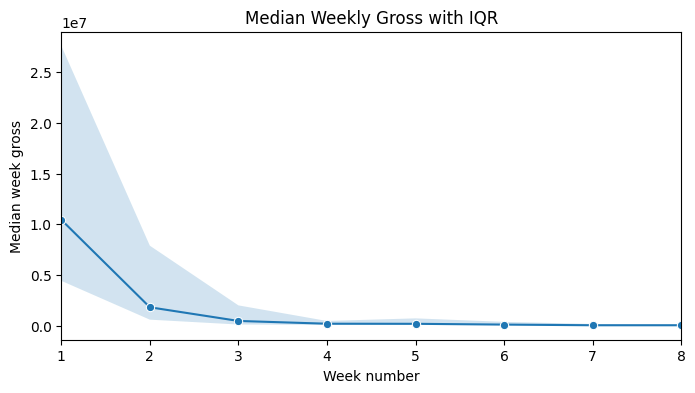

In [20]:
grouped = weekly.groupby('week')['week_gross']
week_med = grouped.median()
week_q25 = grouped.quantile(0.25)
week_q75 = grouped.quantile(0.75)

plt.figure(figsize=(8,4))
sns.lineplot(x=week_med.index, y=week_med.values, marker='o')
plt.fill_between(week_med.index, week_q25.values, week_q75.values, alpha=0.2)
plt.title('Median Weekly Gross with IQR')
plt.xlabel('Week number')
plt.ylabel('Median week gross')
plt.xlim(1,8)
plt.show()

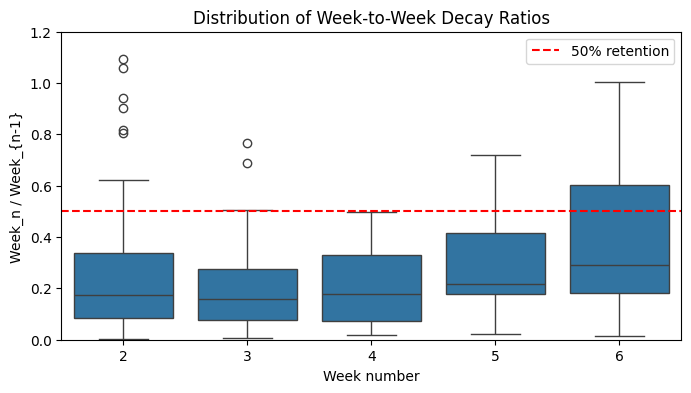

In [21]:
# Boxplot of decay ratios by week
decay_plot = weekly[weekly['week'].between(2,6)]
plt.figure(figsize=(8,4))
sns.boxplot(data=decay_plot, x='week', y='decay_ratio')
plt.axhline(0.5, color='red', linestyle='--', label='50% retention')
plt.ylim(0,1.2)
plt.title('Distribution of Week-to-Week Decay Ratios')
plt.xlabel('Week number')
plt.ylabel('Week_n / Week_{n-1}')
plt.legend()
plt.show()

In [22]:
# Censoring dataset
dataset_end = df['actual_sales_date'].max()

film_dates = (df_run.groupby('numero_film_id', as_index=False)
      .agg(first_date=('actual_sales_date', 'min'),
           last_date=('actual_sales_date', 'max'))
)

# duration in weeks
film_dates = film_dates.merge(longest, on='numero_film_id', how='left')
film_dates['duration_weeks'] = film_dates['run_days_longest'] / 7

# event: 1 if last_date < dataset_end (observed exit), 0 if censored at dataset_end
film_dates['event_observed'] = (film_dates['last_date'] < dataset_end).astype(int)

# merge film-level covariates from your weekly or df (take first or lifetime)
film_meta = (
    df.groupby('numero_film_id', as_index=False)
      .agg(opening_screen_average=('opening_screen_average','first'),
           lifetime_total=('lifetime_total','first'),
           state=('state','first'),
           title=('title','first'))
)
surv_df = film_dates.merge(film_meta, on='numero_film_id', how='left')

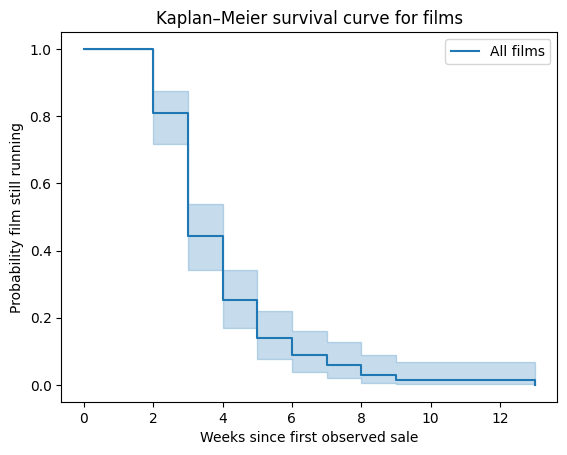

In [23]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
T = surv_df['duration_weeks']
E = surv_df['event_observed']

kmf.fit(T, event_observed=E, label='All films')
ax = kmf.plot(ci_show=True)
ax.set_xlabel('Weeks since first observed sale')
ax.set_ylabel('Probability film still running')
ax.set_title('Kaplan–Meier survival curve for films')
plt.show()

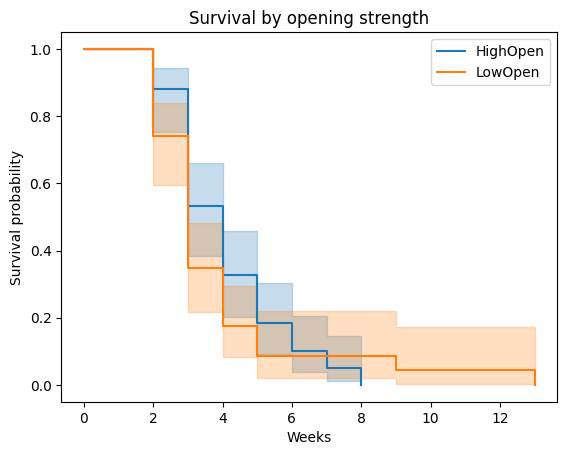

In [24]:
# Stratify by opening strength
median_open = surv_df['opening_screen_average'].median()
surv_df['open_group'] = np.where(surv_df['opening_screen_average'] >= median_open, 'HighOpen', 'LowOpen')

ax = plt.subplot(111)
for name, group in surv_df.groupby('open_group'):
    kmf.fit(group['duration_weeks'], event_observed=group['event_observed'], label=name)
    kmf.plot(ax=ax, ci_show=True)
ax.set_xlabel('Weeks')
ax.set_ylabel('Survival probability')
plt.title('Survival by opening strength')
plt.show()


In [25]:
# number of distinct films observed in each week (films that have any gross in that week)
weekly_counts = (
    weekly.groupby('week', as_index=False)
          .agg(n_films_observed=('numero_film_id', 'nunique'),
               median_week_gross=('week_gross', 'median'),
               total_week_gross=('week_gross', 'sum'))
          .sort_values('week')
)
display(weekly_counts.head(12))

,week,n_films_observed,median_week_gross,total_week_gross
0,1,100,10450528.0,2.139834e+09
1,2,100,1827392.5,7.174678e+08
2,3,77,480253.0,1.943769e+08
3,4,42,206149.0,5.212490e+07
4,5,20,197797.0,1.498665e+07
5,6,11,119812.0,4.305421e+06
6,7,6,54845.0,1.311155e+06
7,8,4,55000.0,5.126040e+05
8,9,2,44050.0,8.810000e+04
9,10,1,117700.0,1.177000e+05


## Daily pattern

In [27]:
# Excluding top 12
top_12_ids = df.groupby('numero_film_id')['gross_today'].sum().sort_values(ascending=False).head(12).index.tolist()
sales_mid_market = df[~df['numero_film_id'].isin(top_12_ids)]

In [28]:
data = sales_mid_market.copy()

data['actual_sales_date'] = pd.to_datetime(data['actual_sales_date'])
data = data.sort_values(['numero_film_id','actual_sales_date'])

# compute film first date and day index (day 1 = first sales date)
data['first_date'] = data.groupby('numero_film_id')['actual_sales_date'].transform('min')
data['day'] = (data['actual_sales_date'] - data['first_date']).dt.days + 1

# daily
daily = (df_run.groupby(['numero_film_id','day'], as_index=False)
           .agg(daily_gross=('gross_today','sum'),
                title=('title','first'),
                state=('state','first'),
                screens=('opening_screens','first')))

daily = daily.sort_values(['numero_film_id','day'])
daily['prev_gross'] = daily.groupby('numero_film_id')['daily_gross'].shift(1)
daily.loc[daily['prev_gross'] == 0, 'prev_gross'] = np.nan
daily['retention'] = (daily['daily_gross'] / daily['prev_gross']).replace([np.inf,-np.inf], np.nan)

# sum of daily gross
sum_by_film = daily.groupby('numero_film_id')['daily_gross'].sum().rename('sum_days').reset_index()
meta = daily.groupby('numero_film_id', as_index=False).agg(lifetime_total=('daily_gross','sum'))

daily = daily.merge(sum_by_film, on='numero_film_id', how='left')
daily['lifetime_use'] = daily['lifetime_total'].fillna(daily['sum_days']) if 'lifetime_total' in daily.columns else daily['sum_days']
daily.loc[daily['lifetime_use'] == 0, 'lifetime_use'] = np.nan
daily['cum_gross'] = daily.groupby('numero_film_id')['daily_gross'].cumsum()
daily['cum_share'] = (daily['cum_gross'] / daily['lifetime_use']).clip(0,1)

# summaries by day
day_summary = (daily.groupby('day').agg(
    n_films=('numero_film_id','nunique'),
    median_daily=('daily_gross','median'),
    median_retention=('retention','median'),
    p25_retention=('retention', lambda s: s.quantile(0.25)),
    p75_retention=('retention', lambda s: s.quantile(0.75)),
    median_cum_share=('cum_share','median')
).reset_index())

# signal table
def pct_reached_day(thresh, d):
    sub = daily[daily['day']==d]
    if len(sub)==0:
        return np.nan
    return (sub['cum_share'] >= thresh).mean()*100

early_table = pd.DataFrame({
    'day':[1,3,7],
    'pct_>=50':[pct_reached_day(0.5,d) for d in [1,3,7]],
    'pct_>=80':[pct_reached_day(0.8,d) for d in [1,3,7]]
})

day_summary.head(14), early_table

(    day  n_films  median_daily  median_retention  p25_retention  \
 0     1      100           0.0               NaN            NaN   
 1     2      100     2037527.0          1.645271       1.113137   
 2     3      100     2962574.0          1.312123       0.945531   
 3     4      100     1772334.0          0.665241       0.535155   
 4     5      100      777007.0          0.494981       0.383165   
 5     6      100      845189.0          1.061600       0.880253   
 6     7      100      526776.0          0.568685       0.451207   
 7     8      100      287808.0          0.509721       0.298135   
 8     9      100      455685.5          1.453031       1.101706   
 9    10      100      540870.0          1.254103       0.949791   
 10   11      100      310092.0          0.618284       0.466269   
 11   12      100      131240.5          0.414853       0.271088   
 12   13      100      141040.5          1.171997       0.765086   
 13   14      100       82903.0          0.51673

In [29]:
df_run['actual_sales_date'] = pd.to_datetime(df_run['actual_sales_date'])
df_run['gross_today'] = pd.to_numeric(df_run['gross_today'], errors='coerce').fillna(0)

film_date = (
    df_run.groupby(['numero_film_id','actual_sales_date'], as_index=False)
          .agg(gross_today=('gross_today','sum'),
               title=('title','first'),
               state=('state','first'),
               opening_screens=('opening_screens','first'),
               opening_screen_average=('opening_screen_average','first'))
)

first_nonzero = (
    film_date[film_date['gross_today'] > 0]
      .groupby('numero_film_id', as_index=False)['actual_sales_date']
      .min()
      .rename(columns={'actual_sales_date':'first_sale_date'})
)

film_date = film_date.merge(first_nonzero, on='numero_film_id', how='left')
film_date['has_sales'] = film_date['first_sale_date'].notna()
film_date['day_from_first_sale'] = (film_date['actual_sales_date'] - film_date['first_sale_date']).dt.days + 1

aligned = film_date[film_date['day_from_first_sale'].notna() & (film_date['day_from_first_sale'] >= 1)].copy()

run_lifetime = aligned.groupby('numero_film_id', as_index=False)['gross_today'].sum().rename(columns={'gross_today':'run_lifetime'})

daily = (
    aligned.groupby(['numero_film_id','day_from_first_sale'], as_index=False)
           .agg(daily_gross=('gross_today','sum'),
                title=('title','first'),
                state=('state','first'),
                screens=('opening_screens','first'))
)

daily = daily.merge(run_lifetime, on='numero_film_id', how='left')
daily = daily.sort_values(['numero_film_id','day_from_first_sale'])
daily['cum_gross'] = daily.groupby('numero_film_id')['daily_gross'].cumsum()
daily['cum_share'] = daily['cum_gross'] / daily['run_lifetime']
daily.loc[daily['run_lifetime'] == 0, 'cum_share'] = np.nan  

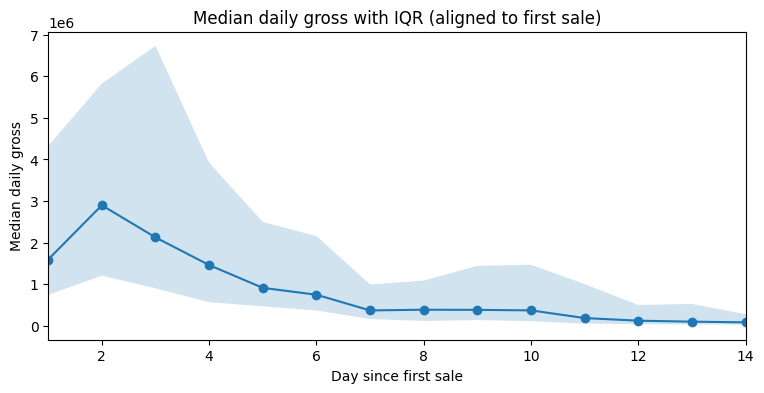

In [30]:
# median daily gross with IQR
plt.figure(figsize=(9,4))
med = daily.groupby('day_from_first_sale')['daily_gross'].median()
p25 = daily.groupby('day_from_first_sale')['daily_gross'].quantile(0.25)
p75 = daily.groupby('day_from_first_sale')['daily_gross'].quantile(0.75)
plt.plot(med.index, med.values, marker='o')
plt.fill_between(med.index, p25.values, p75.values, alpha=0.2)
plt.xlabel('Day since first sale')
plt.ylabel('Median daily gross')
plt.title('Median daily gross with IQR (aligned to first sale)')
plt.xlim(1,14)
plt.show()

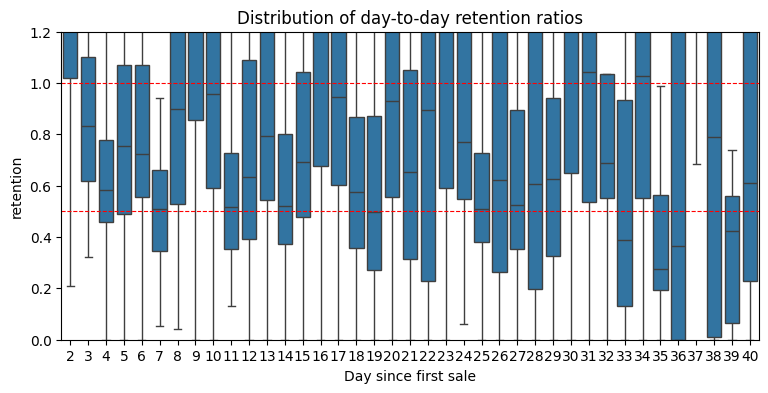

In [31]:
# retention boxplot
daily = daily.sort_values(['numero_film_id','day_from_first_sale'])
daily['prev_gross'] = daily.groupby('numero_film_id')['daily_gross'].shift(1)
daily.loc[daily['prev_gross'] == 0, 'prev_gross'] = np.nan
daily['retention'] = (daily['daily_gross'] / daily['prev_gross']).replace([np.inf, -np.inf], np.nan)

plt.figure(figsize=(9,4))
sns.boxplot(data=daily[daily['day_from_first_sale'].between(2,40)], 
            x='day_from_first_sale', y='retention')
plt.axhline(1, color='red', linestyle='--', linewidth=0.8)
plt.axhline(0.5, color='red', linestyle='--', linewidth=0.8)
plt.ylim(0,1.2)
plt.xlabel('Day since first sale')
plt.title('Distribution of day-to-day retention ratios')
plt.show()


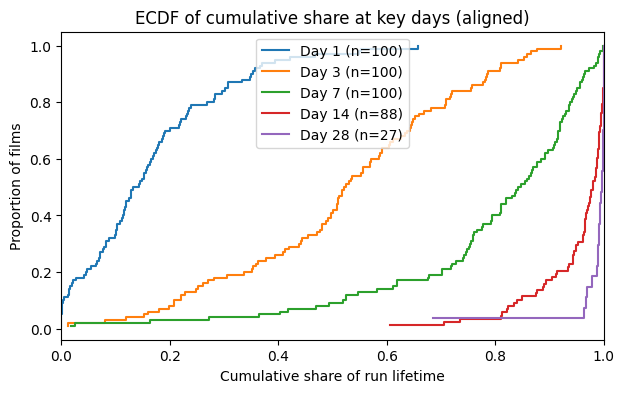

In [32]:
# ECDF cumulative share at key days 
def plot_ecdf_days(days=[1,3,7,14,28]):
    plt.figure(figsize=(7,4))
    for d in days:
        vals = daily.loc[daily['day_from_first_sale']==d,'cum_share'].dropna().values
        if len(vals)==0:
            continue
        vals = np.sort(vals)
        y = np.arange(1,len(vals)+1)/len(vals)
        plt.step(vals, y, where='post', label=f'Day {d} (n={len(vals)})')
    plt.xlim(0,1)
    plt.xlabel('Cumulative share of run lifetime')
    plt.ylabel('Proportion of films')
    plt.legend()
    plt.title('ECDF of cumulative share at key days (aligned)')
    plt.show()

plot_ecdf_days([1,3,7, 14, 28])


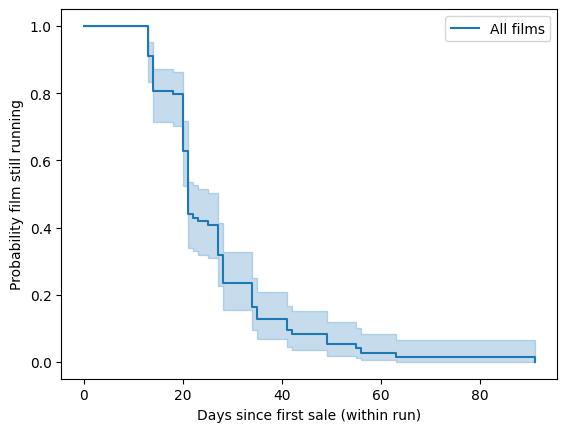

In [33]:
film_days = (aligned.groupby('numero_film_id', as_index=False)
           .agg(first_date=('actual_sales_date','min'),
                last_date=('actual_sales_date','max')))

film_days['duration_days'] = (film_days['last_date'] - film_days['first_date']).dt.days + 1
film_days['event_observed'] = (film_days['last_date'] < dataset_end).astype(int)

kmf = KaplanMeierFitter()
kmf.fit(film_days['duration_days'], event_observed=film_days['event_observed'], label='All films')
ax = kmf.plot(ci_show=True)
ax.set_xlabel('Days since first sale (within run)')
ax.set_ylabel('Probability film still running')
plt.show()


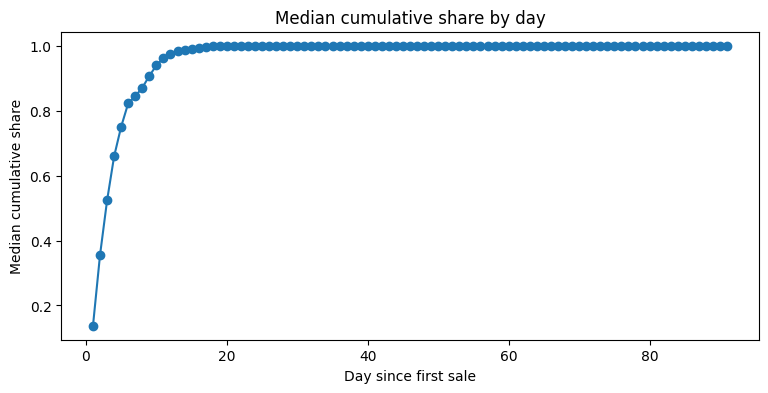

In [35]:
# Revenue capture
max_day = int(daily['day_from_first_sale'].max())
wide = daily.pivot_table(index='numero_film_id',
                         columns='day_from_first_sale',
                         values='cum_share',
                         aggfunc='max').sort_index(axis=1)
wide = wide.ffill(axis=1)
wide.columns = [f'cum_{int(c)}' for c in wide.columns]
capture = wide.reset_index()

days = sorted([int(c.split('_')[1]) for c in capture.columns if c.startswith('cum_')])
medians = {d: np.nanmedian(capture[f'cum_{d}'].values) for d in days}
med_series = pd.Series(medians).sort_index()

plt.figure(figsize=(9,4))
plt.plot(med_series.index, med_series.values, marker='o')
plt.xlabel('Day since first sale')
plt.ylabel('Median cumulative share')
plt.title('Median cumulative share by day')
plt.show()

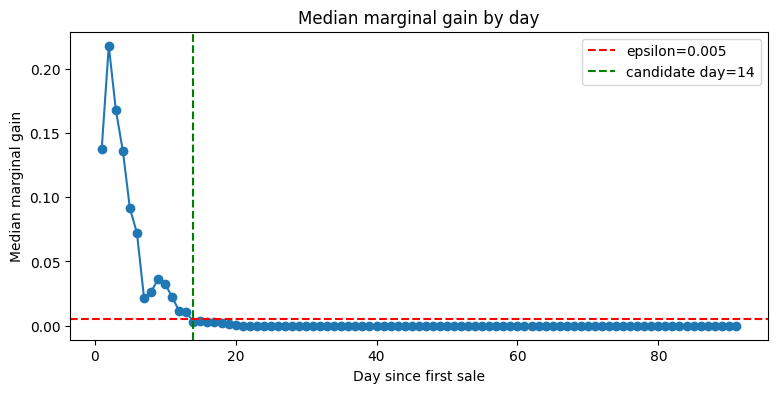

In [36]:
# marginal median gain
delta = med_series.diff().fillna(med_series.iloc[0])

# candidate day
epsilon = 0.005
candidate_day = delta[delta < epsilon].index.min()
d = int(candidate_day)

plt.figure(figsize=(9,4))
plt.plot(delta.index, delta.values, marker='o')
plt.axhline(epsilon, color='red', linestyle='--', label=f'epsilon={epsilon}')
plt.axvline(d, color='green', linestyle='--', label=f'candidate day={candidate_day}')
plt.xlabel('Day since first sale')
plt.ylabel('Median marginal gain')
plt.title('Median marginal gain by day')
plt.legend()
plt.show()

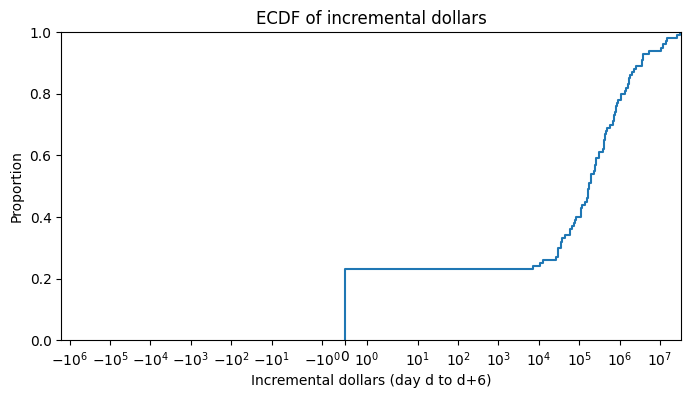

In [37]:
# Bootstrapping
def bootstrap_median(arr, n_boot=2000):
    """estimate a 95% CI for the median of an array using resampling"""
    arr = arr[~np.isnan(arr)]
    boots = []
    for _ in range(n_boot):
        s = np.random.choice(arr, size=len(arr), replace=True)
        boots.append(np.median(s))
    return np.percentile(boots, [2.5,97.5])

# candidate day and candidate_day+6
d = int(candidate_day)
arr_d = capture[f'cum_{d}'].values
arr_d6 = capture[f'cum_{d+6}'].values if f'cum_{d+6}' in capture.columns else np.full(len(capture), np.nan)
ci_d = bootstrap_median(arr_d)
ci_d5 = bootstrap_median(arr_d6)

# incremental dollars day d to d+6
run_lifetime = daily.groupby('numero_film_id', as_index=False)['run_lifetime'].first()
inc = capture.merge(run_lifetime, on='numero_film_id', how='left')
inc['inc_share_d_d6'] = inc[f'cum_{d+6}'] - inc[f'cum_{d}']
inc['inc_dollars_d_d6'] = inc['inc_share_d_d6'] * inc['run_lifetime']

plt.figure(figsize=(8,4))
sns.ecdfplot(inc['inc_dollars_d_d6'].dropna())
plt.xscale('symlog')
plt.xlabel('Incremental dollars (day d to d+6)')
plt.title('ECDF of incremental dollars')
plt.show()

In [38]:
inc[['inc_share_d_d6','inc_dollars_d_d6']].describe(percentiles=[0.5,0.75,0.9,0.95])

,inc_share_d_d6,inc_dollars_d_d6
count,100.000000,1.000000e+02
mean,0.030267,1.657886e+06
std,0.041296,4.829816e+06
min,0.000000,0.000000e+00
50%,0.012702,1.739385e+05
75%,0.037281,8.148375e+05
90%,0.100488,3.514505e+06
95%,0.116831,1.100791e+07
max,0.182901,3.226236e+07


# QUESTION 3: Which release windows are most vulnerable without a blockbuster anchor?

Top 12 film IDs by lifetime_total (candidate outliers): [85118, 82496, 76895, 83671, 78916, 81984, 76162, 80415, 79188, 83519, 80879, 76662]


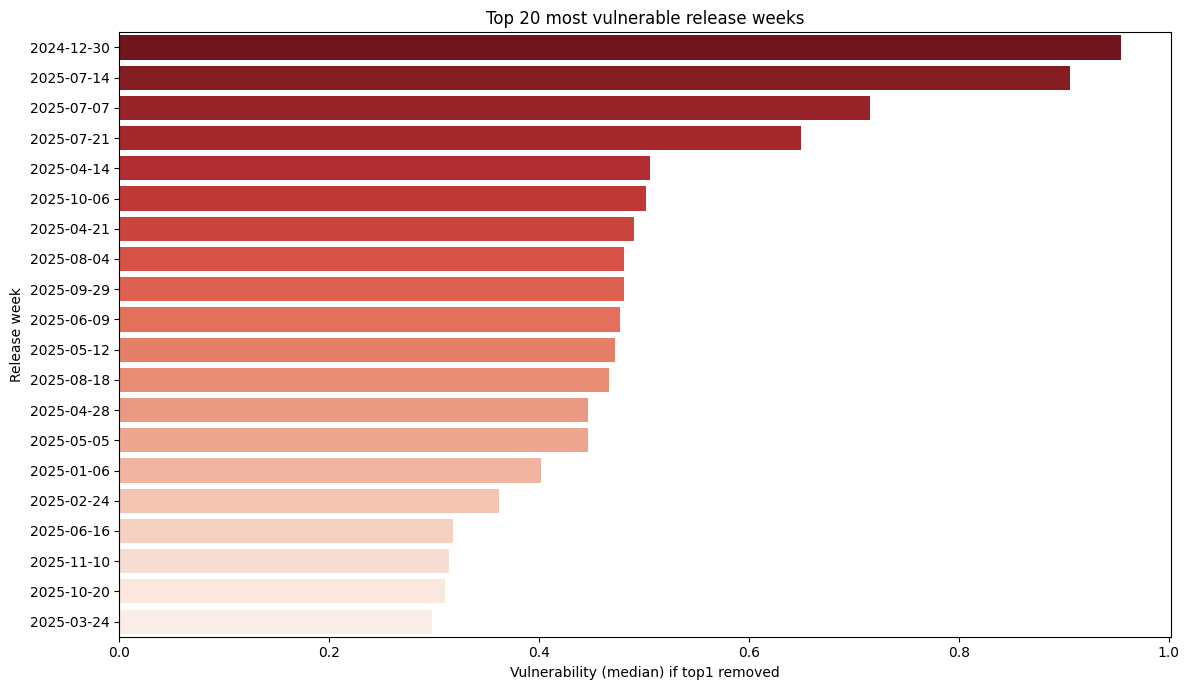

In [39]:
df = df.copy() 
df['week_start_date'] = pd.to_datetime(df['week_start_date'])
df['actual_sales_date'] = pd.to_datetime(df['actual_sales_date'])
start_date = df['actual_sales_date'].min().normalize()
df['release_week'] = df['week_start_date'].dt.to_period('W').apply(lambda r: r.start_time)

# 12 outliers
outlier_by_lifetime = (df[['numero_film_id','lifetime_total']]
                       .drop_duplicates(subset='numero_film_id')
                       .sort_values('lifetime_total', ascending=False)
                       .head(12))
outlier_ids = outlier_by_lifetime['numero_film_id'].tolist()
print("Top 12 film IDs by lifetime_total (candidate outliers):", outlier_ids)
df['is_upper_outlier'] = df['numero_film_id'].isin(outlier_ids)
#  exclude top 12
df_clean = df[~df['is_upper_outlier']].copy()

df_clean['actual_sales_date'] = pd.to_datetime(df_clean['actual_sales_date'])

# anchor start_date to the earliest sales date
start_date = df_clean['actual_sales_date'].min().normalize()

# day index relative to start_date
df_clean['day_index'] = (df_clean['actual_sales_date'] - start_date).dt.days

# non-overlapping windows (start date of each window)
df_clean['window_3d_start'] = (df_clean['day_index'] // 3).apply(lambda i: start_date + pd.Timedelta(days=3*i))
df_clean['window_5d_start'] = (df_clean['day_index'] // 5).apply(lambda i: start_date + pd.Timedelta(days=5*i))

# weekly window (explicit week start)
df_clean['release_week'] = df_clean['actual_sales_date'].dt.to_period('W').apply(lambda r: r.start_time)

# weekend vs weekday (Fri-Sun as weekend)
df_clean['weekday'] = df_clean['actual_sales_date'].dt.weekday  # Mon=0
df_clean['is_weekend'] = df_clean['weekday'].isin([4,5,6])
df_clean['week_start'] = df_clean['actual_sales_date'].dt.to_period('W').apply(lambda r: r.start_time)
df_clean['window_weekend'] = df_clean['week_start'].astype(str) + '_' + df_clean['is_weekend'].map({True:'weekend', False:'weekday'})

# build_film_week
def build_film_week(df_clean, window_col='release_week'):
    film_week = (df_clean.groupby([window_col, 'numero_film_id'], as_index=False)
                 .agg(film_week_gross=('week_gross_at_cinema','sum'),
                      film_opening_week_total=('opening_week_total','max'),
                      opening_screen_average=('opening_screen_average','max'),
                      title=('title','first'),
                      distributor=('distributor','first')))
    film_week = film_week.rename(columns={window_col: 'window_start'})
    return film_week

# film by time
film_week_weekly = build_film_week(df_clean, window_col='release_week')
film_week_3d = build_film_week(df_clean, window_col='window_3d_start')
film_week_5d = build_film_week(df_clean, window_col='window_5d_start')
film_week_weekend = build_film_week(df_clean, window_col='window_weekend')

# window aggregates
window = (film_week_weekly.groupby('window_start', as_index=False)
          .agg(total_gross_window=('film_week_gross','sum'),
               median_week_gross=('film_week_gross','median'),
               mean_week_gross=('film_week_gross','mean'),
               n_releases=('numero_film_id','nunique')))

# compute top1 and top2 per window
film_week_sorted = film_week_weekly.sort_values(['window_start','film_week_gross'], ascending=[True,False])
top_per_week = (film_week_sorted.groupby('window_start')
                .apply(lambda g: g.reset_index(drop=True).loc[0:1, ['numero_film_id','film_week_gross']])
                .reset_index(level=0, drop=True)
                .reset_index()
               )

# pivot top1/top2
top1 = (film_week_sorted.groupby('window_start', as_index=False)
        .nth(0)[['window_start','numero_film_id','film_week_gross']]
        .rename(columns={'numero_film_id':'top1_id','film_week_gross':'top1_gross'}))

top2 = (film_week_sorted.groupby('window_start', as_index=False)
        .nth(1)[['window_start','numero_film_id','film_week_gross']]
        .rename(columns={'numero_film_id':'top2_id','film_week_gross':'top2_gross'}))

window = window.merge(top1, on='window_start', how='left')
window = window.merge(top2, on='window_start', how='left')

# compute top1_share
window['top1_share'] = window['top1_gross'] / window['total_gross_window']
window['top2_share'] = window['top2_gross'] / window['total_gross_window']

# without top1 (and top1+top2)
film_week_with_top = film_week_weekly.merge(top1[['window_start','top1_id']], on='window_start', how='left')
film_week_no_top1 = film_week_with_top[film_week_with_top['numero_film_id'] != film_week_with_top['top1_id']]

window_no_top1 = (film_week_no_top1.groupby('window_start', as_index=False)
                  .agg(median_week_gross_no_top1=('film_week_gross','median'),
                       total_gross_no_top1=('film_week_gross','sum')))

# remove top1+top2
film_week_with_top2 = film_week_weekly.merge(top2[['window_start','top2_id']], on='window_start', how='left')
film_week_no_top12 = film_week_with_top.merge(top2[['window_start','top2_id']], on='window_start', how='left')
film_week_no_top12 = film_week_no_top12[(film_week_no_top12['numero_film_id'] != film_week_no_top12['top1_id']) &
                                        (film_week_no_top12['numero_film_id'] != film_week_no_top12['top2_id'])]

window_no_top12 = (film_week_no_top12.groupby('window_start', as_index=False)
                   .agg(median_week_gross_no_top12=('film_week_gross','median'),
                        total_gross_no_top12=('film_week_gross','sum')))

# merge
window = window.merge(window_no_top1, on='window_start', how='left')
window = window.merge(window_no_top12, on='window_start', how='left')

# Vulnerability metrics
window['vuln_median_top1'] = (window['median_week_gross'] - window['median_week_gross_no_top1']) / window['median_week_gross']
window['vuln_total_top1'] = (window['total_gross_window'] - window['total_gross_no_top1']) / window['total_gross_window']
window['vuln_median_top12'] = (window['median_week_gross'] - window['median_week_gross_no_top12']) / window['median_week_gross']
window['vuln_total_top12'] = (window['total_gross_window'] - window['total_gross_no_top12']) / window['total_gross_window']
for col in ['vuln_median_top1','vuln_total_top1','vuln_median_top12','vuln_total_top12']:
    window[col] = window[col].replace([np.inf, -np.inf], np.nan)

window = window.sort_values('vuln_median_top1', ascending=False).reset_index(drop=True)

# Top 20 most vulnerable weeks
top20 = window.head(20).copy()
plt.figure(figsize=(12,7))
sns.barplot(data=top20, x='vuln_median_top1', y=top20['window_start'].dt.strftime('%Y-%m-%d'), palette='Reds_r')
plt.xlabel('Vulnerability (median) if top1 removed')
plt.ylabel('Release week')
plt.title('Top 20 most vulnerable release weeks')
plt.tight_layout()
plt.show()

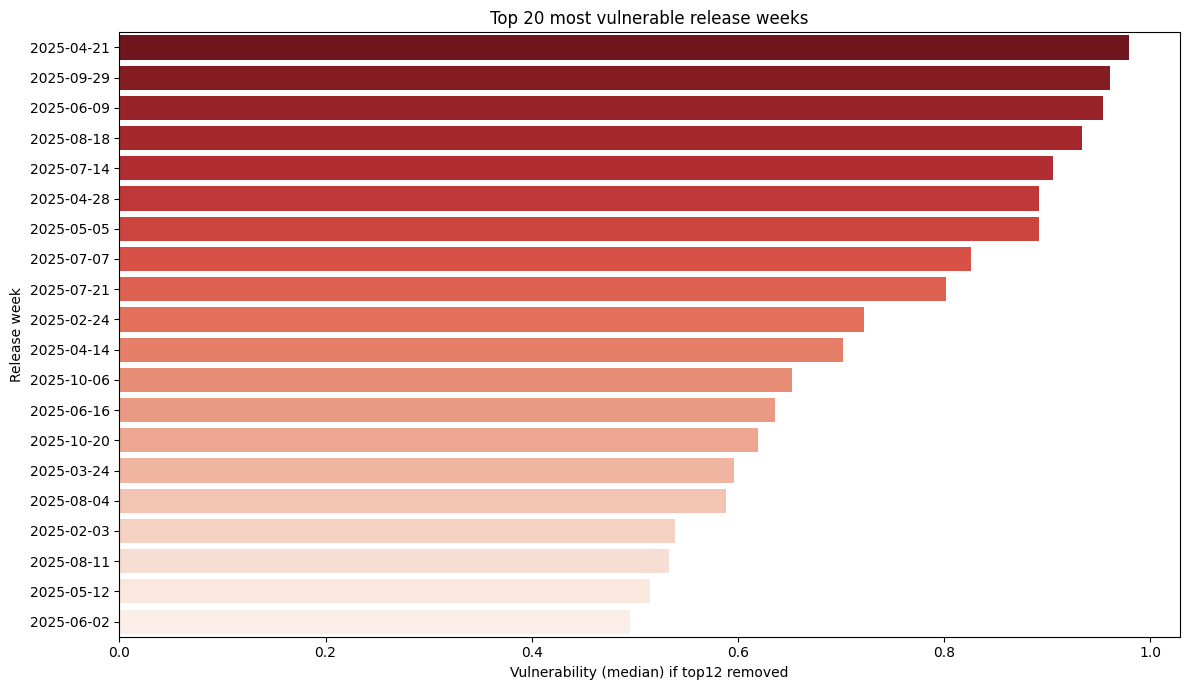

In [40]:
window = window.sort_values('vuln_median_top12', ascending=False).reset_index(drop=True)
top20 = window.head(20).copy()
plt.figure(figsize=(12,7))
sns.barplot(data=top20, x='vuln_median_top12', y=top20['window_start'].dt.strftime('%Y-%m-%d'), palette='Reds_r')
plt.xlabel('Vulnerability (median) if top12 removed')
plt.ylabel('Release week')
plt.title('Top 20 most vulnerable release weeks')
plt.tight_layout()
plt.show()

In [41]:
def compute_vulnerability_by_k(film_week, release_week_col='window_start',
                               film_id_col='numero_film_id', gross_col='film_week_gross',
                               K=5, drop_outliers_ids=None, bootstrap=False, n_boot=1000):
    df = film_week.copy()
    if drop_outliers_ids is not None:
        df = df[~df[film_id_col].isin(drop_outliers_ids)].copy()

    # aggregates per window
    base = (df.groupby(release_week_col, as_index=False)
              .agg(total_gross=('film_week_gross','sum'),
                   median_gross=('film_week_gross','median'),
                   n_releases=(film_id_col,'nunique')))
    
    # concentration metrics
    def herfindahl(group):
        s = group[gross_col] / group[gross_col].sum()
        return (s**2).sum()
    def gini(group):
        arr = np.sort(group[gross_col].values)
        n = len(arr)
        if n == 0: return np.nan
        cum = np.cumsum(arr)
        return (2*np.sum((np.arange(1,n+1) * arr)) / (n*arr.sum())) - (n+1)/n

    conc = (df.groupby(release_week_col).apply(lambda g: pd.Series({
                'herfindahl': herfindahl(g),
                'gini': gini(g)
            })).reset_index())

    base = base.merge(conc, on=release_week_col, how='left')

    rows = []
    df_sorted = df.sort_values([release_week_col, gross_col], ascending=[True, False])
    grouped = {k: g for k,g in df_sorted.groupby(release_week_col)}

    for week, g in grouped.items():
        n = g[film_id_col].nunique()
        total = g[gross_col].sum()
        median = g[gross_col].median()
        ordered_ids = g[[film_id_col, gross_col]].drop_duplicates(subset=film_id_col).sort_values(gross_col, ascending=False)[film_id_col].tolist()
        for k in range(1, min(K, len(ordered_ids)) + 1):
            remove_ids = set(ordered_ids[:k])
            g_no = g[~g[film_id_col].isin(remove_ids)]
            total_no = g_no[gross_col].sum()
            median_no = g_no[gross_col].median() if len(g_no)>0 else np.nan
            topk_share = sum(g[g[film_id_col].isin(remove_ids)][gross_col]) / total if total>0 else np.nan
            vuln_total = (total - total_no) / total if total>0 else np.nan
            vuln_median = (median - median_no) / median if (median>0 and not np.isnan(median_no)) else np.nan

            row = {
                release_week_col: week,
                'k': k,
                'n_releases': n,
                'total_gross': total,
                'median_gross': median,
                'total_gross_no_topk': total_no,
                'median_gross_no_topk': median_no,
                'topk_share': topk_share,
                'vuln_total': vuln_total,
                'vuln_median': vuln_median
            }
            rows.append(row)

    out = pd.DataFrame(rows)
    out = out.merge(base, on=release_week_col, how='left')
    # bootstrap for median drop per (week,k)
    if bootstrap:
        def bootstrap_median_diff_unpaired(a, b, n_boot=2000):
            a = np.asarray(a.dropna()) if hasattr(a, "dropna") else np.asarray(a)
            b = np.asarray(b.dropna()) if hasattr(b, "dropna") else np.asarray(b)
            if len(a) < 2 or len(b) < 2:
                return (np.nan, np.nan)  
            diffs = []
            for _ in range(n_boot):
                sa = np.random.choice(a, size=len(a), replace=True)
                sb = np.random.choice(b, size=len(b), replace=True)
                diffs.append(np.median(sa) - np.median(sb))
            return np.percentile(diffs, [2.5, 97.5])

        def bootstrap_median_diff_paired(a, b, n_boot=2000):
            a = np.asarray(a)
            b = np.asarray(b)
            if len(a) != len(b) or len(a) < 2:
                return (np.nan, np.nan)   
            idx = np.arange(len(a))
            diffs = []
            for _ in range(n_boot):
                s = np.random.choice(idx, size=len(idx), replace=True)
                diffs.append(np.median(a[s]) - np.median(b[s]))
            return np.percentile(diffs, [2.5, 97.5])

        def safe_bootstrap_median_diff(a, b, n_boot=2000, paired=False):
            if paired:
                return bootstrap_median_diff_paired(a, b, n_boot=n_boot)
            else:
                return bootstrap_median_diff_unpaired(a, b, n_boot=n_boot)

        cis_low, cis_high = [], []
        for _, r in out.iterrows():
            week = r[release_week_col]; k = int(r['k'])
            g = grouped[week]
            ordered_ids = g[[film_id_col, gross_col]].drop_duplicates(subset=film_id_col).sort_values(gross_col, ascending=False)[film_id_col].tolist()
            remove_ids = set(ordered_ids[:k])
            a = g[gross_col]
            b = g[~g[film_id_col].isin(remove_ids)][gross_col]
            low, high = safe_bootstrap_median_diff(a, b, n_boot=n_boot, paired=False)
            cis_low.append(low); cis_high.append(high)
        out['median_drop_ci_low'] = cis_low
        out['median_drop_ci_high'] = cis_high

    return out


In [42]:
res_weekly = compute_vulnerability_by_k(film_week_weekly, K=10, drop_outliers_ids=outlier_ids, bootstrap=True, n_boot=500)
res_3d = compute_vulnerability_by_k(film_week_3d, K=10, drop_outliers_ids=outlier_ids, bootstrap=True, n_boot=500)
res_5d = compute_vulnerability_by_k(film_week_5d, K=10, drop_outliers_ids=outlier_ids, bootstrap=True, n_boot=500)
res_weekend = compute_vulnerability_by_k(film_week_weekend, K=10, drop_outliers_ids=outlier_ids, bootstrap=True, n_boot=500)

In [43]:
# pick worst k per window
def worst_k_per_window(res, window_col='window_start'):
    most_vuln = res.loc[res.groupby(window_col)['vuln_median'].idxmax()].reset_index(drop=True)
    # add a robust flag: CI excludes 0 and enough releases
    most_vuln['robust'] = (most_vuln['median_drop_ci_low'].notna()) & \
                         (most_vuln['median_drop_ci_low'] > 0) & \
                         (most_vuln['n_releases_x'] >= 4)
    return most_vuln

most_vuln_weekly  = worst_k_per_window(res_weekly,  window_col='window_start')
most_vuln_3d      = worst_k_per_window(res_3d,      window_col='window_start')
most_vuln_5d      = worst_k_per_window(res_5d,      window_col='window_start')
most_vuln_weekend = worst_k_per_window(res_weekend, window_col='window_start')

In [44]:
# comparison table
def summary_stats(mv):
    return {
        'vuln_rate': mv['robust'].mean(),
        'modal_k': int(mv['k'].mode().iloc[0]) if not mv['k'].mode().empty else None,
        'median_topk_share': mv['topk_share'].median()
        # 'median_n_releases': mv['n_releases_x'].median()
    }

comparison = pd.DataFrame({
    'weekly':  summary_stats(most_vuln_weekly),
    '3d':      summary_stats(most_vuln_3d),
    '5d':      summary_stats(most_vuln_5d),
    'weekend': summary_stats(most_vuln_weekend)
}).T

comparison

,vuln_rate,modal_k,median_topk_share
weekly,0.043478,10.0,0.998898
3d,0.019048,7.0,0.997806
5d,0.015873,7.0,0.998558
weekend,0.021978,7.0,0.997814


In [45]:
# # pick worst k per window
# def ensure_n_releases(res, film_week, window_col='window_start'):
#     if 'n_releases' not in res.columns:
#         base = (film_week.groupby(window_col, as_index=False)
#                 .agg(n_releases=('numero_film_id','nunique')))
#         res = res.merge(base, on=window_col, how='left')
#     return res

# res_weekly = ensure_n_releases(res_weekly, film_week_weekly, window_col='window_start')

# most_vuln_weekly = res_weekly.loc[res_weekly.groupby('window_start')['vuln_median'].idxmax()].reset_index(drop=True)
# most_vuln_weekly['robust'] = (most_vuln_weekly['median_drop_ci_low'].notna()) & \
#                              (most_vuln_weekly['median_drop_ci_low'] > 0) & \
#                              (most_vuln_weekly['n_releases'] >= 4)

# # filter to vulnerable windows
# vulnerable = most_vuln_weekly[(most_vuln_weekly['vuln_median'] >= 0.5) & (most_vuln_weekly['median_drop_ci_low'] > 0) & (most_vuln_weekly['n_releases'] >= 4)]
# vulnerable = vulnerable.sort_values('vuln_median', ascending=False)

# # attach anchor film names and grosses for the worst k
# def get_anchors(window_start, k, film_week):
#     dfw = film_week[film_week['window_start']==window_start].sort_values('film_week_gross', ascending=False)
#     anchors = dfw.head(k)[['numero_film_id','title','film_week_gross']].to_dict('records')
#     return anchors

# vulnerable['anchors'] = vulnerable.apply(lambda r: get_anchors(r['window_start'], int(r['k']), film_week_weekly), axis=1)

# table = vulnerable[['window_start','k','n_releases','vuln_median','topk_share','median_drop_ci_low','median_drop_ci_high','anchors']].reset_index(drop=True)
# table.head(20)  # show top 20

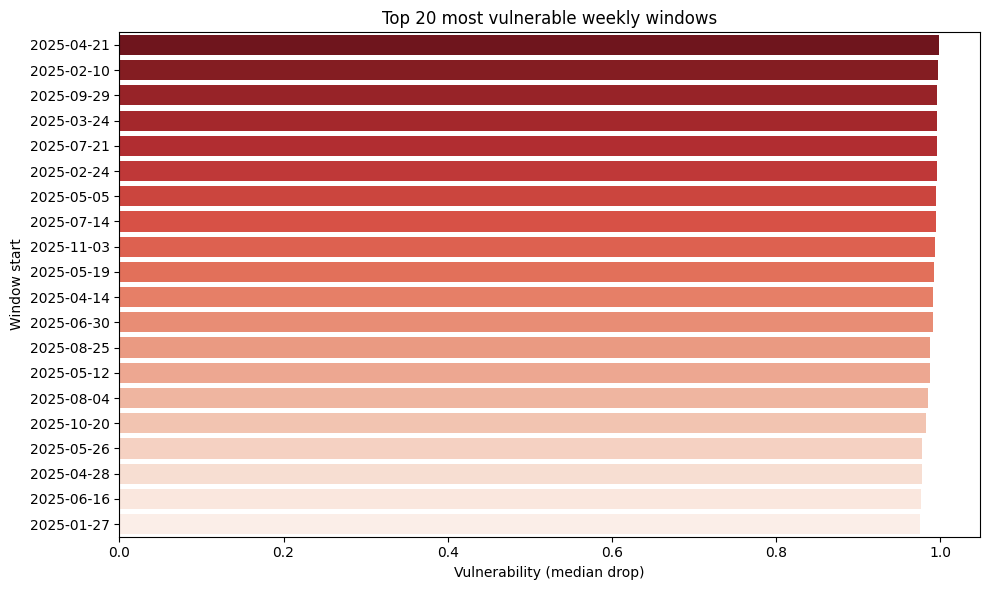

In [46]:
# top N vulnerable windows
top20_weekly = most_vuln_weekly.sort_values('vuln_median', ascending=False).head(20)
# frequency of worst-k
k_freq_weekly = most_vuln_weekly['k'].value_counts().sort_index()
# vulnerability rate
vuln_rate_weekly = most_vuln_weekly['robust'].mean()

# Top 20 bar chart (weekly)
plt.figure(figsize=(10,6))
sns.barplot(data=top20_weekly, x='vuln_median', y=top20_weekly['window_start'].astype(str), palette='Reds_r')
plt.xlabel('Vulnerability (median drop)')
plt.ylabel('Window start')
plt.title('Top 20 most vulnerable weekly windows')
plt.tight_layout()

In [47]:
# top20_weekly

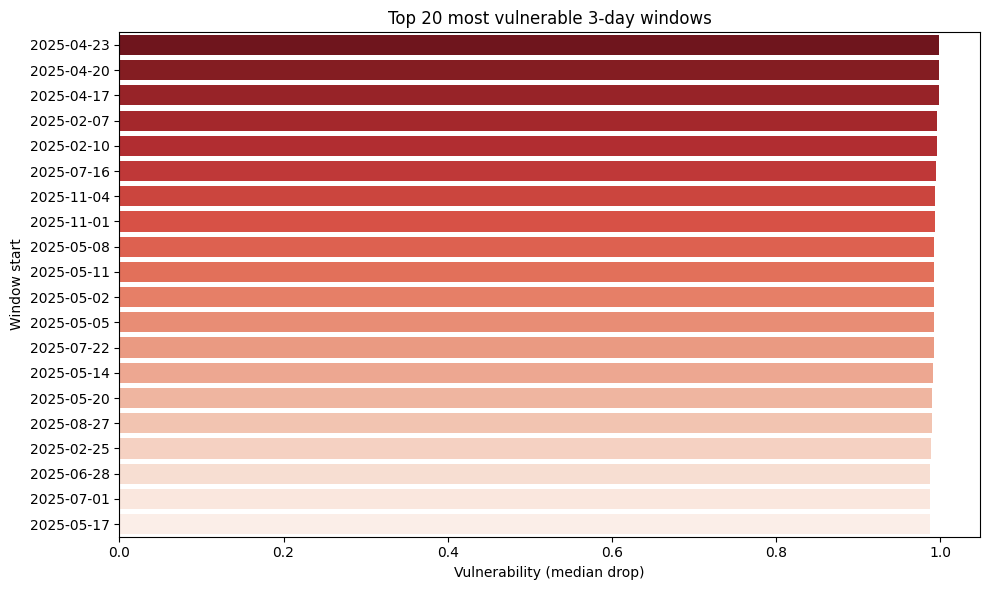

In [48]:
# top N vulnerable windows (3-day)
top20_3d = most_vuln_3d.sort_values('vuln_median', ascending=False).head(20)
# frequency of worst-k
k_freq_3d = most_vuln_3d['k'].value_counts().sort_index()
# vulnerability rate
vuln_rate_3d = most_vuln_3d['robust'].mean()

# Top 20 bar chart (3-day)
plt.figure(figsize=(10,6))
sns.barplot(data=top20_3d, x='vuln_median', y=top20_3d['window_start'].astype(str), palette='Reds_r')
plt.xlabel('Vulnerability (median drop)')
plt.ylabel('Window start')
plt.title('Top 20 most vulnerable 3-day windows')
plt.tight_layout()

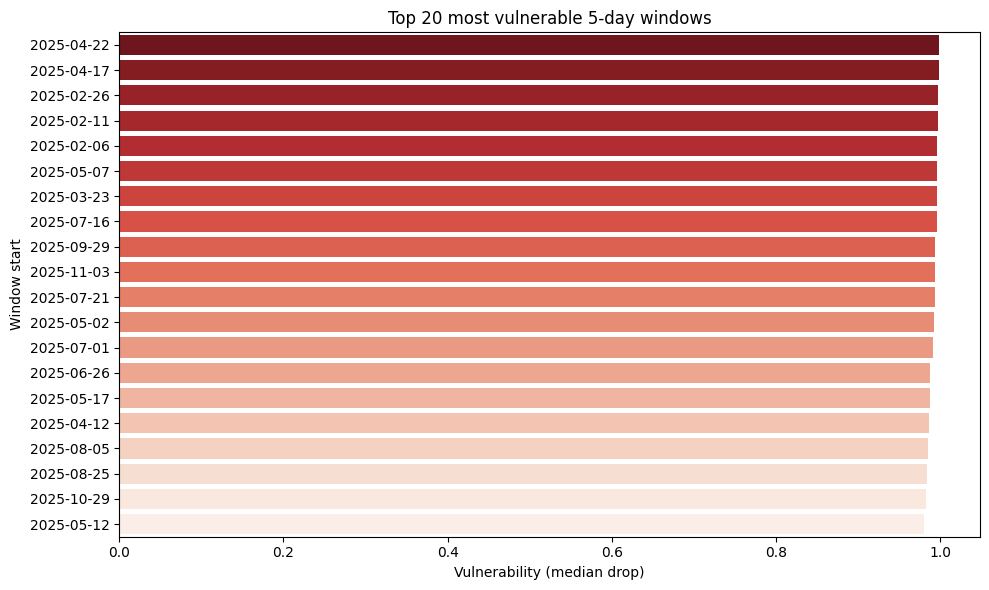

In [49]:
# top N vulnerable windows (5-day)
top20_5d = most_vuln_5d.sort_values('vuln_median', ascending=False).head(20)
# frequency of worst-k
k_freq_5d = most_vuln_5d['k'].value_counts().sort_index()
# vulnerability rate
vuln_rate_5d = most_vuln_5d['robust'].mean()

# Top 20 bar chart (5-day)
plt.figure(figsize=(10,6))
sns.barplot(data=top20_5d, x='vuln_median', y=top20_5d['window_start'].astype(str), palette='Reds_r')
plt.xlabel('Vulnerability (median drop)')
plt.ylabel('Window start')
plt.title('Top 20 most vulnerable 5-day windows')
plt.tight_layout()

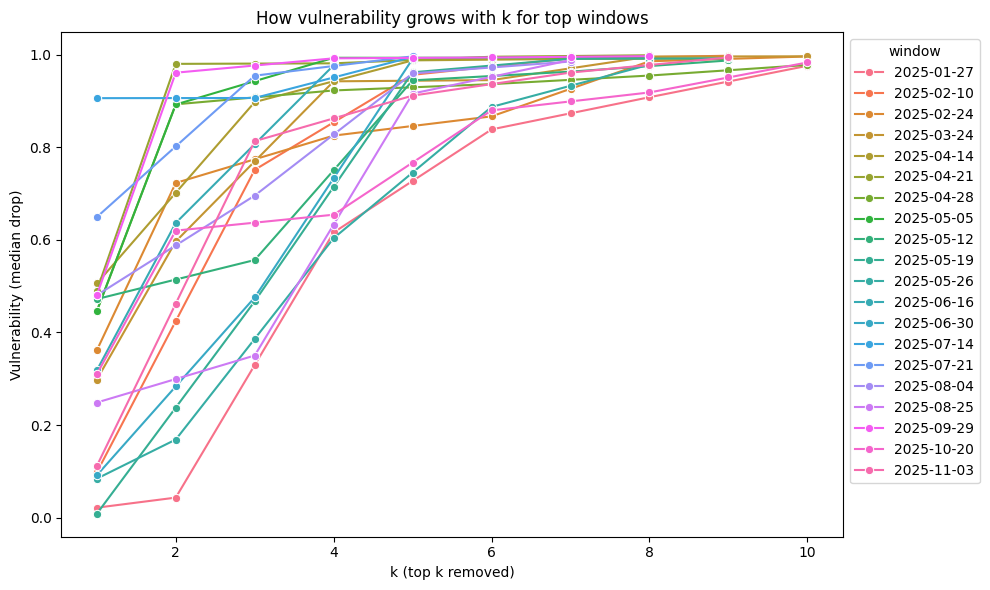

In [50]:
# k vs vuln for top N windows 
top_windows = top20_weekly['window_start'].unique()
plot_df = res_weekly[res_weekly['window_start'].isin(top_windows)]
plt.figure(figsize=(10,6))
sns.lineplot(data=plot_df, x='k', y='vuln_median', hue=plot_df['window_start'].astype(str), marker='o')
plt.xlabel('k (top k removed)')
plt.ylabel('Vulnerability (median drop)')
plt.title('How vulnerability grows with k for top windows')
plt.legend(title='window', bbox_to_anchor=(1,1))
plt.tight_layout()

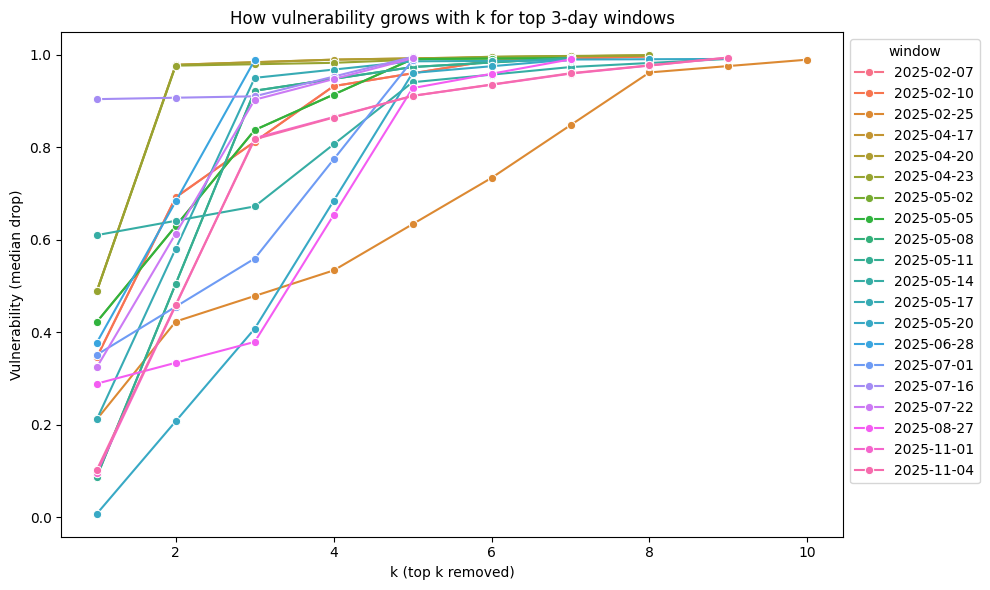

In [51]:
top_windows_3d = top20_3d['window_start'].unique()
plot_df_3d = res_3d[res_3d['window_start'].isin(top_windows_3d)]
plt.figure(figsize=(10,6))
sns.lineplot(data=plot_df_3d, x='k', y='vuln_median', hue=plot_df_3d['window_start'].astype(str), marker='o')
plt.xlabel('k (top k removed)')
plt.ylabel('Vulnerability (median drop)')
plt.title('How vulnerability grows with k for top 3-day windows')
plt.legend(title='window', bbox_to_anchor=(1,1))
plt.tight_layout()

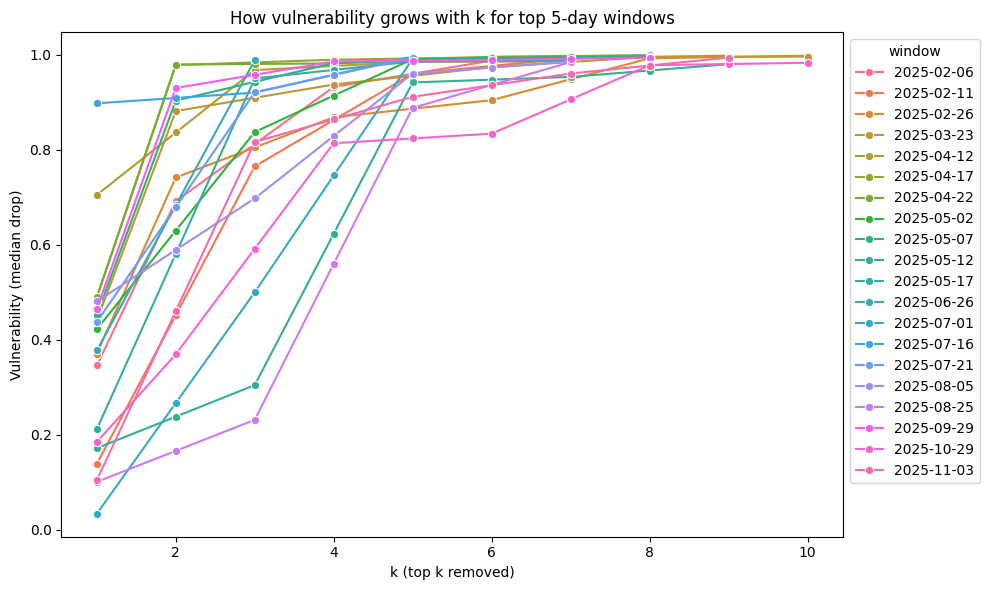

In [52]:
top_windows_5d = top20_5d['window_start'].unique()
plot_df_5d = res_5d[res_5d['window_start'].isin(top_windows_5d)]
plt.figure(figsize=(10,6))
sns.lineplot(data=plot_df_5d, x='k', y='vuln_median', hue=plot_df_5d['window_start'].astype(str), marker='o')
plt.xlabel('k (top k removed)')
plt.ylabel('Vulnerability (median drop)')
plt.title('How vulnerability grows with k for top 5-day windows')
plt.legend(title='window', bbox_to_anchor=(1,1))
plt.tight_layout()

In [ ]:
# # Heatmap over time (weekly)
# pivot = res_weekly.pivot_table(index='window_start', columns='k', values='vuln_median', aggfunc='max').fillna(0)
# plt.figure(figsize=(12,8))
# sns.heatmap(pivot.sort_index(), cmap='Reds', cbar_kws={'label':'vuln_median'})
# plt.title('Vulnerability heatmap (weekly) by k')
# plt.tight_layout()